In [12]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import scipy.special as sp
from decimal import Decimal, getcontext
getcontext().prec = 600

In [2]:
def delays(novelties,flag):
    delay = np.diff(novelties)
    delay = np.array([i for i in delay if i!=1])
    delay = np.array([i-1 for i in delay])
    if(flag == True):
        return np.log(delay)
    else:
        return delay

In [3]:
path = os.getcwd()

In [4]:
all_files = glob.glob(os.path.join(path, '*.txt'))

In [27]:
#FACCIO UNA LISTA IN CUI CARICO TUTTI I DELAY E RELATIVE FREQUENZE
t_min = 10**6
list_delays = []
max_delay = 0
for file in all_files:
    a = np.loadtxt(file)
    for idx,j in enumerate(a):
        if(j>t_min):
            ref = idx
            break
    
    delays_ = delays(a[idx:],False)
    if (np.max(delays_)>max_delay):
        max_delay = np.max(delays_)
    b = np.unique(delays_,return_counts=True)
    list_delays.append([b[0],b[1]/np.sum(b[1])])

In [20]:
len(list_delays)

102

In [28]:
dels = np.arange(1,max_delay+1)

In [29]:
#TESTO SE È TUTTO NORMALIZZATO
prova = 0
for i in list_delays:
    prova+=sum(i[1])

In [30]:
def transform_array_optimized(values, frequencies, lower_bound, upper_bound):
    value_freq_map = dict(zip(values, frequencies))
    
    result_values = list(range(lower_bound, upper_bound + 1))
    result_frequencies = [value_freq_map.get(value, 0) for value in result_values]

    return np.array(result_frequencies)

# Example usage:
original_values = [2, 4, 6, 8, 10]
original_frequencies = [3, 1, 2, 4, 1]
lower_bound = 2
upper_bound = 12

result_frequencies = transform_array_optimized(original_values, original_frequencies, lower_bound, upper_bound)

print("Result Frequencies:", result_frequencies)


Result Frequencies: [3 0 1 0 2 0 4 0 1 0 0]


In [31]:
frequencies = np.zeros(int(max_delay))
for delays_freqs in list_delays:
    frequencies += transform_array_optimized(delays_freqs[0],delays_freqs[1],1,int(max_delay))
    

In [32]:
frequencies/=102

In [33]:
frequencies

array([2.36618061e-03, 2.38935756e-03, 2.44996920e-03, ...,
       0.00000000e+00, 0.00000000e+00, 2.47761475e-06])

In [19]:
np.sum(frequencies)

1.02

In [13]:
def binomial_coeff_lists(lmax):
    b_c = [[Decimal(0) for i in range(lmax)] for j in range(lmax) ]
    for j in range(0,lmax):
        b_c[j][0] = Decimal(1)
        b_c[0][j] = Decimal(1)
        b_c[j][j] = Decimal(1)
    for k in range(1,lmax):
        for s in range(1,k):
            b_c[k][s] = Decimal(b_c[k-1][s]) + Decimal(b_c[k-1][s-1])
    return b_c

def compute_terms(nu,rho,l_max,t_max,t_min):
    frac = Decimal(nu/rho)
    gamma = Decimal(1-nu/rho)
    norm = Decimal(t_max - t_min)
    const = ((Decimal(rho-nu))**(Decimal(frac)))*Decimal(frac)
    const_array = [(Decimal(-1)**(i))*Decimal(const**(i+1)) for i in range(0,l_max)]
    values = [Decimal(1/norm) for i in range (0,l_max)]
    if(nu%(rho-nu)==0):
        print('divergenza!')
        idx_div = int(nu/(rho-nu))
        times_array_pre_div = [ ((Decimal(t_min)**(-Decimal(gamma*(i+1))+Decimal(1)))-(Decimal(t_max)**(-Decimal(gamma*(i+1))+Decimal(1))))/(Decimal(gamma*(i+1)-1)) for i in range(0,idx_div)]
        times_array_pre_div.append(Decimal(np.log(t_max/t_min)))
        times_array_after_div = [ ((Decimal(t_min)**(-Decimal(gamma*(i+1))+Decimal(1)))-(Decimal(t_max)**(-Decimal(gamma*(i+1))+Decimal(1))))/(Decimal(gamma*(i+1)-1)) for i in range(idx_div+1,l_max)]
        times_array = times_array_pre_div+times_array_after_div
    
    else:
        times_array = [ ((Decimal(t_min)**(-Decimal(gamma*(i+1))+Decimal(1)))-(Decimal(t_max)**(-Decimal(gamma*(i+1))+Decimal(1))))/(Decimal(gamma*(i+1)-1)) for i in range(0,l_max)]
        
    for idx in range(0,l_max):
        values[idx] = const_array[idx]*times_array[idx]*values[idx]
    return values

def probability_distribution(nu,rho,l_max,t_max,t_min):
    binomial_coefficients = binomial_coeff_lists(l_max)
    vals = compute_terms(nu,rho,l_max,t_max,t_min)
    lengths= np.arange(1,l_max+1)
    pdf_values = [Decimal(0) for i in range(0,l_max+1)]
    for length in lengths:
        for j in range (0,int(length)):
            pdf_values[int(length)] += Decimal(binomial_coefficients[int(length-1)][j])*Decimal(vals[j])        
    return lengths,pdf_values

In [16]:
x,y = probability_distribution(3,5,2000,10000000,1000)

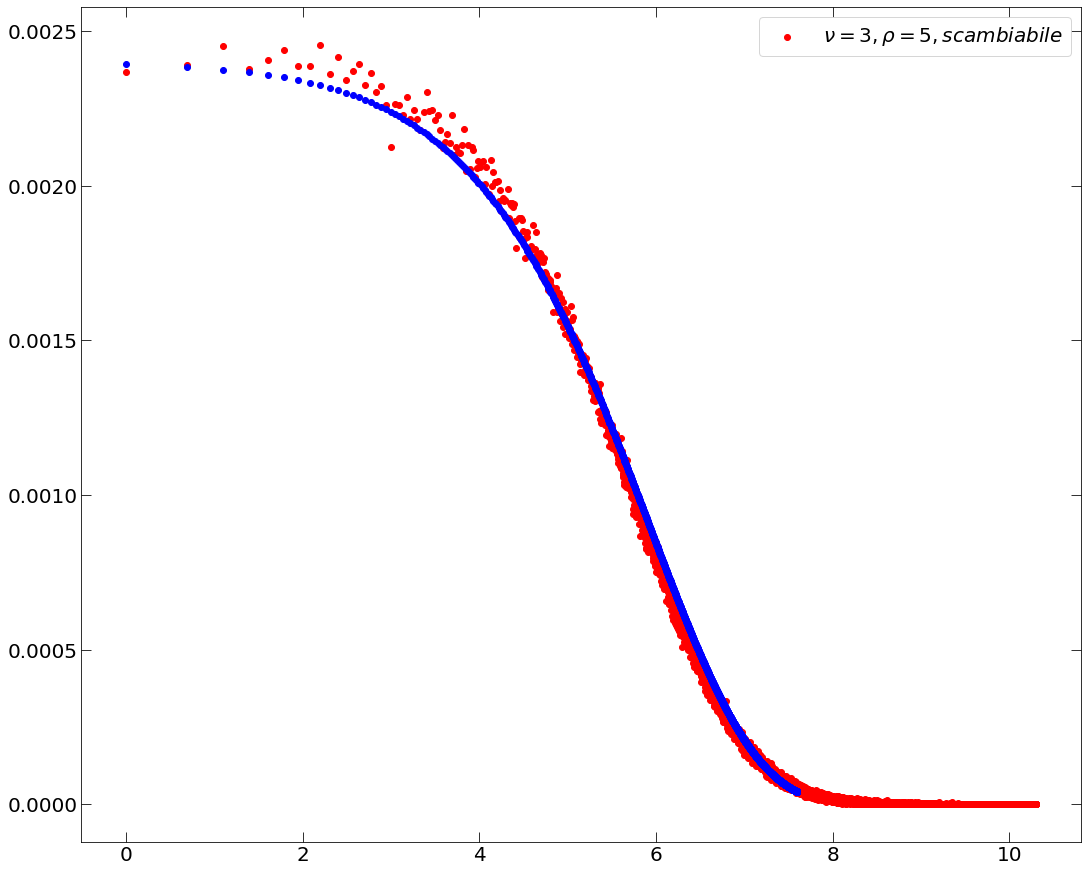

In [34]:
fig, axs = plt.subplots(figsize=(15,12),constrained_layout=True)

axs.scatter(np.log(dels),frequencies,color = 'r',label=r'$\nu=3,\rho=5,scambiabile$')
axs.scatter(np.log(x),y[1:],color = 'b')
#axs.set_xscale('log')
#axs.set_yscale('log')
axs.xaxis.set_tick_params(labelsize=20)
axs.yaxis.set_tick_params(labelsize=20)
axs.tick_params(axis='both',top=True, bottom=True,right= True, 
               labeltop=False, labelbottom=True,direction='in',length=10)
axs.legend(fontsize="20" )
plt.show()